<a href="https://colab.research.google.com/github/hwangho-kim/Utility-OAC/blob/main/CSV_Input_Based_Automated_FDC_Analysis_with_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'sample_fdc_data.csv' 이름으로 데모용 샘플 CSV 파일을 생성합니다.
샘플 파일 생성 완료.

--- Step 1: 데이터 로드 및 컬럼 탐지 ---
Wafer ID 컬럼으로 'wafer_id'을 사용합니다.
총 10개의 센서 컬럼을 탐지했습니다: ['Sensor_A', 'Sensor_B', 'Sensor_C', 'Sensor_D', 'Sensor_E', 'Sensor_F', 'Sensor_G', 'Sensor_H', 'Sensor_I', 'Sensor_J']

--- Step 2: 자동 eps 추정 및 DBSCAN 군집화 ---
자동으로 찾은 최적의 eps 값: 3.1293


<Figure size 1000x700 with 0 Axes>

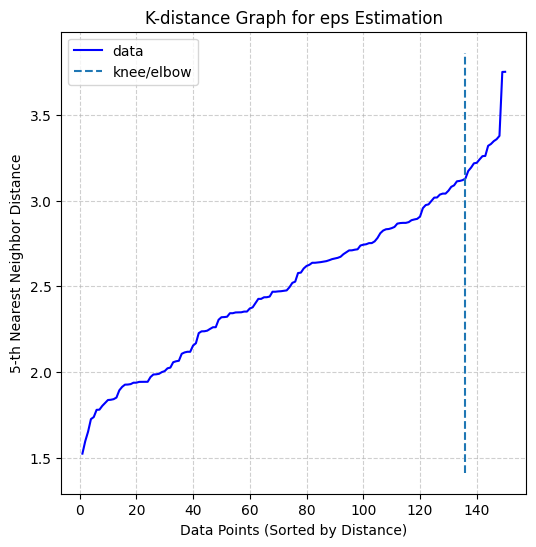


DBSCAN 군집화 결과:
  0    148
-1      2
Name: count, dtype: int64

가장 큰 군집(정상 상태로 추정): Cluster 0

--- Step 3: PCA 모델 학습 및 상태 인덱스 계산 ---
정상으로 식별된 데이터(Golden Dataset) 개수: 148
PCA 모델 학습 완료. 선택된 주성분 개수: 9
Health Index 계산 및 조정 완료 (최솟값 0).

--- Step 4: 최종 결과 시각화 ---


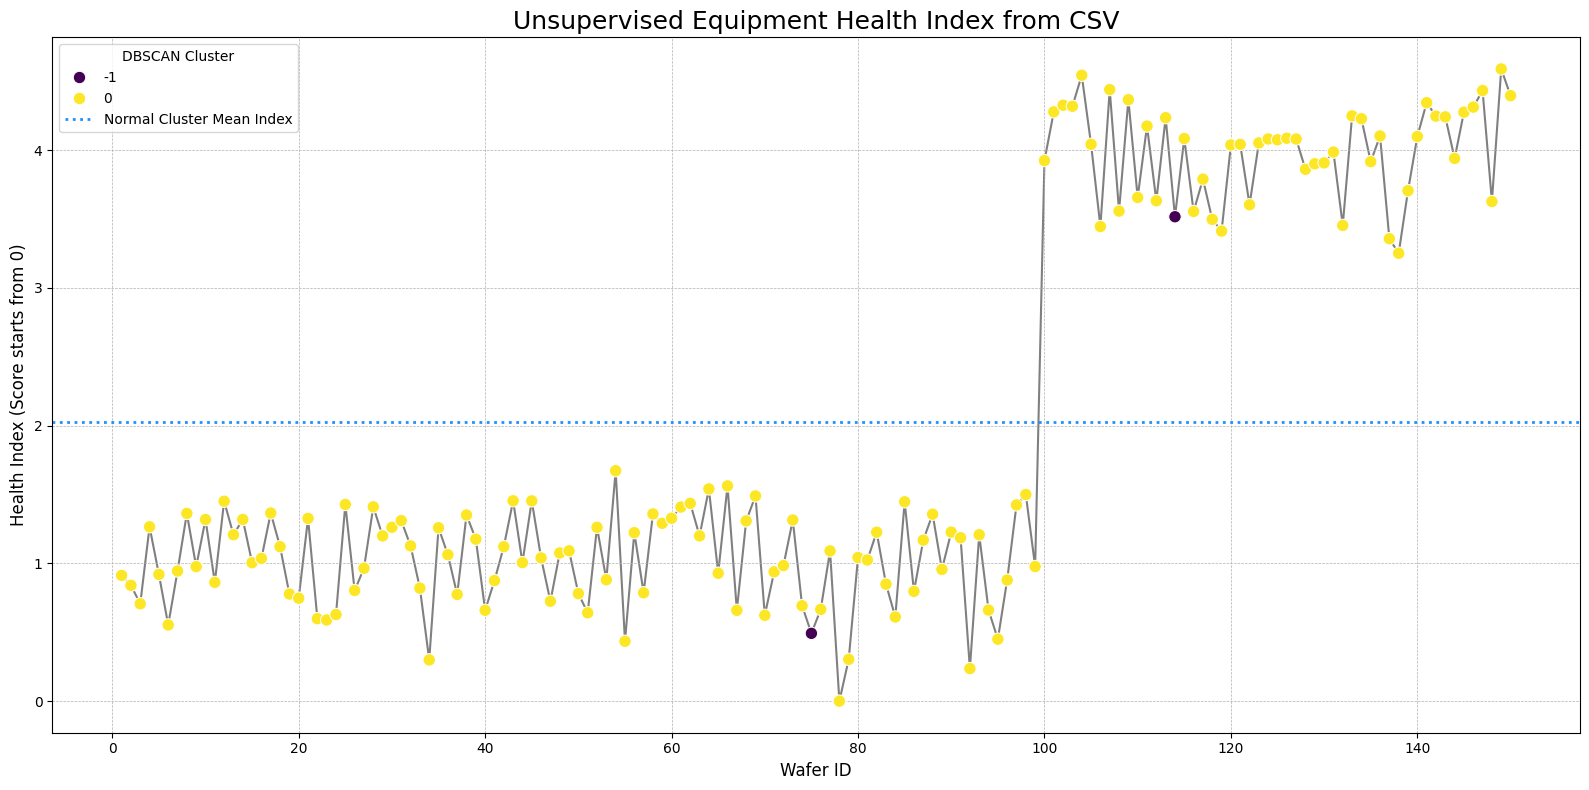


--- Step 5: 이상 Wafer 원인 분석 ---
Health Index 기준 상위 5개 이상 Wafer 진단 결과:

[1] Wafer ID: 114 (Health Index: 3.52)
  > 상위 원인 센서 (Z-score):
    - Sensor_A: 2.82
    - Sensor_F: 1.70
    - Sensor_H: -1.65

[2] Wafer ID: 75 (Health Index: 0.49)
  > 상위 원인 센서 (Z-score):
    - Sensor_A: -2.82
    - Sensor_C: 2.27
    - Sensor_H: 1.50


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# --- 그래프 한글 폰트 설정 ---
try:
    import koreanize_matplotlib
except ImportError:
    pass

def create_sample_csv(filepath='sample_fdc_data.csv'):
    """
    분석을 시연하기 위한 샘플 CSV 파일을 생성합니다. (Wide Format)
    """
    print(f"'{filepath}' 이름으로 데모용 샘플 CSV 파일을 생성합니다.")
    num_wafers = 150
    anomaly_start_wafer = 100
    np.random.seed(42)

    data = {'wafer_id': range(1, num_wafers + 1)}

    # 10개의 센서 데이터 생성
    for i in range(1, 11):
        sensor_name = f'Sensor_{chr(64+i)}'
        data[sensor_name] = np.random.randn(num_wafers) * (i * 0.2) + (i * 10)

    # 이상 상태 주입
    data['Sensor_B'][anomaly_start_wafer-1:] += 5
    data['Sensor_D'][anomaly_start_wafer-1:] *= 1.5

    df = pd.DataFrame(data)
    df.to_csv(filepath, index=False)
    print("샘플 파일 생성 완료.")
    return df

def find_columns(df):
    """
    DataFrame에서 Wafer ID 컬럼과 센서 컬럼들을 자동으로 탐지합니다.
    """
    wafer_id_candidates = ['wafer_id', 'waferid', 'wafer', 'wfr_id', 'wafer_no', 'lot_wafer']
    wafer_id_col = None
    for col in df.columns:
        if col.lower() in wafer_id_candidates:
            wafer_id_col = col
            break

    if wafer_id_col is None:
        print("경고: 'wafer_id'와 유사한 컬럼을 찾지 못했습니다. 첫 번째 컬럼을 Wafer ID로 가정합니다.")
        wafer_id_col = df.columns[0]

    sensor_cols = df.select_dtypes(include=np.number).columns.tolist()
    if wafer_id_col in sensor_cols:
        sensor_cols.remove(wafer_id_col)

    return wafer_id_col, sensor_cols

def diagnose_abnormal_wafers(df, golden_df, wafer_id_col, sensor_cols, top_n=5):
    """
    상태가 나쁜 Wafer들에 대해 원인 센서를 진단합니다.
    """
    print("\n--- Step 5: 이상 Wafer 원인 분석 ---")

    # 정상 군집의 통계량 계산 (평균, 표준편차)
    normal_stats = golden_df[sensor_cols].agg(['mean', 'std'])

    # 분석 대상 선정: 정상 군집에 속하지 않은 Wafer들
    main_cluster_label = golden_df['dbscan_cluster'].iloc[0]
    abnormal_df = df[df['dbscan_cluster'] != main_cluster_label].copy()

    if abnormal_df.empty:
        print("분석할 이상 Wafer가 없습니다. 모든 Wafer가 정상 군집에 속합니다.")
        return

    # Health Index가 높은 순서(가장 나쁜 순서)로 정렬
    abnormal_df = abnormal_df.sort_values(by='health_index', ascending=False)

    print(f"Health Index 기준 상위 {top_n}개 이상 Wafer 진단 결과:")

    for i, row in enumerate(abnormal_df.head(top_n).itertuples()):
        wafer_id = getattr(row, wafer_id_col)

        # Z-score 계산
        z_scores = {}
        for sensor in sensor_cols:
            val = getattr(row, sensor)
            mean = normal_stats.loc['mean', sensor]
            std = normal_stats.loc['std', sensor]
            if std > 0: # 표준편차가 0인 경우(값이 모두 동일)는 제외
                z_score = (val - mean) / std
                z_scores[sensor] = z_score

        # Z-score 절댓값이 큰 순서로 정렬
        sorted_sensors = sorted(z_scores.items(), key=lambda item: abs(item[1]), reverse=True)

        print(f"\n[{i+1}] Wafer ID: {wafer_id} (Health Index: {row.health_index:.2f})")
        print("  > 상위 원인 센서 (Z-score):")
        for sensor, score in sorted_sensors[:3]: # 상위 3개 센서만 출력
            print(f"    - {sensor}: {score:.2f}")

def analyze_fdc_from_csv(filepath):
    """
    CSV 파일을 입력받아 FDC 상태 인덱스 분석을 자동으로 수행하는 메인 함수
    """
    try:
        from kneed import KneeLocator
    except ImportError:
        print("오류: 'kneed' 라이브러리가 설치되지 않았습니다.")
        print("분석을 계속하려면 터미널이나 명령 프롬프트에서 아래 명령어를 실행해주세요:")
        print("pip install kneed")
        return

    # --- 1. 데이터 로드 및 컬럼 자동 탐지 ---
    print("\n--- Step 1: 데이터 로드 및 컬럼 탐지 ---")
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"오류: '{filepath}' 파일을 찾을 수 없습니다. 파일 이름과 경로를 확인해주세요.")
        return

    wafer_id_col, sensor_cols = find_columns(df)

    if not sensor_cols:
        print("오류: 분석할 숫자형 센서 데이터 컬럼을 찾을 수 없습니다.")
        return

    print(f"Wafer ID 컬럼으로 '{wafer_id_col}'을 사용합니다.")
    print(f"총 {len(sensor_cols)}개의 센서 컬럼을 탐지했습니다: {sensor_cols}")

    if df[sensor_cols].isnull().sum().sum() > 0:
        print("결측치를 발견하여 중앙값(median)으로 대체합니다.")
        for col in sensor_cols:
            df[col].fillna(df[col].median(), inplace=True)

    # --- 2. 자동 eps 추정 및 DBSCAN 군집화 ---
    print("\n--- Step 2: 자동 eps 추정 및 DBSCAN 군집화 ---")
    X = df[sensor_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    min_samples = 5
    nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors = nearest_neighbors.fit(X_scaled)
    distances, _ = neighbors.kneighbors(X_scaled)
    sorted_distances = np.sort(distances[:, min_samples-1])

    kneedle = KneeLocator(x=range(1, len(sorted_distances)+1), y=sorted_distances, S=1.0, curve="convex", direction="increasing")
    optimal_eps = kneedle.elbow_y

    if optimal_eps is None:
        print("경고: 최적의 eps 값을 자동으로 찾지 못했습니다. 기본값으로 대체합니다.")
        optimal_eps = np.median(sorted_distances)

    print(f"자동으로 찾은 최적의 eps 값: {optimal_eps:.4f}")

    plt.figure(figsize=(10, 7))
    kneedle.plot_knee()
    plt.xlabel("Data Points (Sorted by Distance)")
    plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
    plt.title("K-distance Graph for eps Estimation")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    df['dbscan_cluster'] = clusters

    cluster_counts = pd.Series(clusters).value_counts()
    print("\nDBSCAN 군집화 결과:\n", cluster_counts)

    if -1 in cluster_counts.index and len(cluster_counts) > 1:
        main_cluster_label = cluster_counts.drop(-1).idxmax()
    else:
        main_cluster_label = cluster_counts.idxmax()
    print(f"\n가장 큰 군집(정상 상태로 추정): Cluster {main_cluster_label}")

    # --- 3. PCA 모델 학습 및 상태 인덱스 계산 ---
    print("\n--- Step 3: PCA 모델 학습 및 상태 인덱스 계산 ---")
    golden_df = df[df['dbscan_cluster'] == main_cluster_label].copy()

    if golden_df.empty:
        print("오류: 정상 군집을 찾지 못했습니다. 데이터가 너무 분산되어 있거나 eps 파라미터 조정이 필요할 수 있습니다.")
        return

    print(f"정상으로 식별된 데이터(Golden Dataset) 개수: {len(golden_df)}")

    scaler_pca = StandardScaler()
    golden_features_scaled = scaler_pca.fit_transform(golden_df[sensor_cols])

    pca_model = PCA(n_components=0.95)
    pca_model.fit(golden_features_scaled)
    print(f"PCA 모델 학습 완료. 선택된 주성분 개수: {pca_model.n_components_}")

    all_features_scaled = scaler_pca.transform(df[sensor_cols])
    all_pca_scores = pca_model.transform(all_features_scaled)

    # --- [수정됨] Health Index 계산 및 조정 ---
    # Raw PC1 score를 Health Index의 기반으로 사용
    raw_health_index = all_pca_scores[:, 0]

    # Health Index의 최솟값이 0이 되도록 전체 점수를 이동(shift)
    min_index_value = raw_health_index.min()
    df['health_index'] = raw_health_index - min_index_value

    print("Health Index 계산 및 조정 완료 (최솟값 0).")


    # --- 4. 최종 결과 시각화 ---
    print("\n--- Step 4: 최종 결과 시각화 ---")
    plt.figure(figsize=(16, 8))
    sns.lineplot(x=wafer_id_col, y='health_index', data=df, marker='o', color='gray', zorder=1, label='_nolegend_')
    sns.scatterplot(x=wafer_id_col, y='health_index', data=df, hue='dbscan_cluster', palette='viridis', s=80, zorder=2)

    normal_mean_index = df[df['dbscan_cluster'] == main_cluster_label]['health_index'].mean()
    plt.axhline(y=normal_mean_index, color='dodgerblue', linestyle=':', linewidth=2, label=f'Normal Cluster Mean Index')

    plt.title('Unsupervised Equipment Health Index from CSV', fontsize=18)
    plt.xlabel('Wafer ID', fontsize=12)
    plt.ylabel('Health Index (Score starts from 0)', fontsize=12)
    plt.legend(title='DBSCAN Cluster')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- 5. 이상 Wafer 원인 분석 ---
    diagnose_abnormal_wafers(df, golden_df, wafer_id_col, sensor_cols, top_n=5)


if __name__ == '__main__':
    # --- 실행 ---
    create_sample_csv(filepath='sample_fdc_data.csv')
    csv_file_path = 'sample_fdc_data.csv'
    analyze_fdc_from_csv(csv_file_path)

In [1]:
!pip install kneed